In [1]:
import numpy as np
import os 
from PIL import Image
import matplotlib.pyplot as plt
from utils import load_image, show
from downsample import downsample
from upsample import upsample
from downsample.interpolation import pixel_unshuffle_downsample
from filters import apply_spatial_filter, apply_freq_filter, filter
from utils import (
    calculate_mse,
    calculate_psnr,
    calculate_ssim,
    calculate_lpips
)

from tqdm import tqdm
from metrics import ImageMetricsCalculator
from metrics import write_exp_results, print_metrics

In [2]:
# 定义所有的上采样和下采样方法
downsample_names = [
    'neighbor', 'bilinear', 'bicubic', 'unshuffle',
    'max_pooling', 'min_pooling', 'avg_pooling', 'l2_pooling',
    'random_conv2d', 'mean_conv2d', 'gaussion_conv2d', 'lanczos_conv2d'
]

filter_names = [
    'gaussian_lowpass', 'ideal_lowpass', 'butterworth_lowpass',
    'mean_spatial', 'gaussian_spatial', 'sinc_spatial', 'lanczos_spatial', 'kaiser_spatial'
] 

upsample_names = [
    'neighbor', 'bilinear', 'bicubic', 'shuffle',
    'TCN', 'ESPCN', "RDN", "SRCNN"
]

scale_factor = 2 # Experiment Hyper Param

## Foundations

1. Load test image;
2. Apply down/up sampling functions on test image;
3. Apply filters on test image

(392, 300, 3) float32


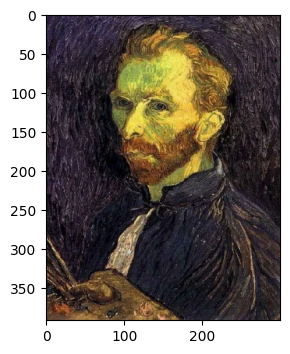

AssertionError: Skip check steps

In [3]:
img = load_image('asserts/VanGogh.jpg')
print(img.shape, img.dtype)
show(img)
assert False, "Skip check steps"

In [ ]:
for name in tqdm(downsample_names, desc="check downsample"):
    if 'unshuffle' in name.lower():
        print('skip pixel unshuffle for downsampling')
        # print(name, pixel_unshuffle_downsample(img, 2, return_list=False).shape)
        continue
    lr_img = downsample(img, 2, ds_name=name)

check downsample:  25%|██▌       | 3/12 [00:02<00:07,  1.15it/s]

skip pixel unshuffle for downsampling


check downsample: 100%|██████████| 12/12 [00:11<00:00,  1.01it/s]


In [ ]:
for name in tqdm(upsample_names, desc="check upsample"):
    if 'shuffle' in name.lower():
        print('skip pixel shuffle for upsampling')
        # print(name, pixel_unshuffle_downsample(img, 2, return_list=False).shape)
        continue    
    hr_img = upsample(img, 2, us_name=name)

check upsample:  43%|████▎     | 3/7 [00:38<01:05, 16.34s/it]

skip pixel shuffle for upsampling


check upsample: 100%|██████████| 7/7 [01:43<00:00, 14.77s/it]


In [ ]:
for name in tqdm(filter_names):
    res = filter(img, name)

100%|██████████| 8/8 [00:12<00:00,  1.59s/it]


## Experiments

`pipeline` function is used to apply a downsampling-upsampling process with or without a filter. Change the name to see other algorithms.

In [4]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
calculator = ImageMetricsCalculator(device=device)

def pipeline(image, name_down, name_up, name_filter=None, scale_factor=2):
    device = calculator.device
    if name_filter is not None:
        img_filtered = filter(image, name_filter)
    else:
        img_filtered = image

    lr_image = downsample(img_filtered, scale_factor, name_down)

    new_image = upsample(lr_image, scale_factor, name_up, device=device)

    metrics = calculator.calculate_all(image, new_image)

    return new_image, metrics
assert False


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/24_zhangxiao/environment/anaconda3/envs/sampling/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/24_zhangxiao/environment/anaconda3/envs/sampling/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/24_zhangxiao/environment/anaconda3/envs/sampling/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth


AssertionError: 

### Exp1: Select Upsampling

Downsampling from DIV2Kx4 $\to$ DIV2Kx8

In [ ]:
def evaluate_upsamplings(
    up_name,
    lr_path="./dataset/DIV2K/valid/X8/", 
    hr_path="./dataset/DIV2K/valid/X4/", 
    scale_factor=2,
    calculator=calculator
):
    metrics = {
        'mse': [],
        'psnr': [],
        'ssim': [],
        'lpips': []
    }

    lr_imgs = sorted(os.listdir(lr_path))
    lr_img_paths = [os.path.join(lr_path, f) for f in lr_imgs]
    hr_imgs = sorted(os.listdir(hr_path))
    hr_img_paths = [os.path.join(hr_path, f) for f in hr_imgs]

    # print(lr_imgs)
    # print(hr_imgs)
    if len(lr_imgs) == len(hr_imgs):
        for lr, hr in tqdm(
            zip(lr_img_paths, hr_img_paths), 
            total=len(lr_imgs),
            desc=f"Evaluating {up_name}",
            ncols=100
        ):
            lr_img = load_image(lr, adjust=False)
            hr_img0 = load_image(hr)

            # upsample from lr_img
            hr_img = upsample(lr_img, scale_factor, up_name)
            img_metrics = calculator.calculate_all(hr_img0, hr_img, data_range=1.0)
            for key, val in img_metrics.items():
                metrics[key].append(val)
    
    return {key: np.mean(metrics[key]) for key in metrics}       

In [ ]:
upsample_results = {}
for name in upsample_names:
    if name in upsample_results.keys():
        print(name, ':', upsample_results[name])
        continue
    if 'shuffle' in name:
        continue
    try:
        upsample_results[name] = evaluate_upsamplings(name)
        prin(upsample_results[name])
    except Exception as error:
        print(error)
        print(f"Unvalid upsampling {upsample_results[name]}")

Evaluating neighbor: 100%|████████████████████████████████████████| 100/100 [00:19<00:00,  5.18it/s]


Unvalid upsampling {'mse': 5.074830201845515e-08, 'psnr': 73.78371131896972, 'ssim': 0.9999204587936401, 'lpips': 3.266600258939434e-05}


Evaluating bilinear: 100%|████████████████████████████████████████| 100/100 [04:56<00:00,  2.97s/it]


Unvalid upsampling {'mse': 4.378747608502209e-08, 'psnr': 74.4593130493164, 'ssim': 0.9999192825953165, 'lpips': 5.651845432112168e-05}


Evaluating bicubic: 100%|█████████████████████████████████████████| 100/100 [15:59<00:00,  9.59s/it]


Unvalid upsampling {'mse': 4.626807919461129e-08, 'psnr': 74.25405403137206, 'ssim': 0.9999058000246684, 'lpips': 4.1701378818288505e-05}


Evaluating shuffleTCN:   0%|                                                | 0/100 [00:00<?, ?it/s]


KeyError: 'shuffleTCN'

In [ ]:
for name in ['TCN', 'ESPCN', 'RDN', 'SRCNN']:
    if name in upsample_results.keys():
        print(name)
        print(upsample_results[name])
        continue
    try:
        upsample_results[name] = evaluate_upsamplings(name)
        prin(upsample_results[name])
    except Exception as error:
        print(error)
        print(f"Unvalid upsampling {upsample_results[name]}")

TCN
{'mse': 3.8104676489680856e-08, 'psnr': 75.09613525390625, 'ssim': 0.999931540489197, 'lpips': 1.2814282225690476e-05}


Evaluating ESPCN: 100%|███████████████████████████████████████████| 100/100 [15:45<00:00,  9.46s/it]


name 'prin' is not defined
Unvalid upsampling {'mse': 3.497011768383018e-08, 'psnr': 75.5747484588623, 'ssim': 0.9999345811208087, 'lpips': 6.7328827287838066e-06}


Evaluating RDN: 100%|█████████████████████████████████████████████| 100/100 [00:49<00:00,  2.02it/s]


name 'prin' is not defined
Unvalid upsampling {'mse': 3.335066312781798e-08, 'psnr': 75.85279602050781, 'ssim': 0.9999394496281941, 'lpips': 6.448411942301391e-06}


Evaluating SRCNN: 100%|███████████████████████████████████████████| 100/100 [16:40<00:00, 10.00s/it]

name 'prin' is not defined
Unvalid upsampling {'mse': 3.857350626361722e-06, 'psnr': 54.8711030960083, 'ssim': 0.9657468787829079, 'lpips': 0.000467424708258477}


In [ ]:
upsample_results = {
  'neighbor' : {'mse': 5.074830201845515e-08, 'psnr': 73.78371131896972, 'ssim': 0.9999204587936401, 'lpips': 3.266600258939434e-05},
  'bilinear' : {'mse': 4.378747608502209e-08, 'psnr': 74.4593130493164, 'ssim': 0.9999192825953165, 'lpips': 5.651845432112168e-05},
  'bicubic' : {'mse': 4.626807919461129e-08, 'psnr': 74.25405403137206, 'ssim': 0.9999058000246684, 'lpips': 4.1701378818288505e-05},
  'TCN' : {'mse': 3.8104676489680856e-08, 'psnr': 75.09613525390625, 'ssim': 0.999931540489197, 'lpips': 1.2814282225690476e-05},
  'ESPCN' : {'mse': 3.497011768383018e-08, 'psnr': 75.5747484588623, 'ssim': 0.9999345811208087, 'lpips': 6.7328827287838066e-06},
  'RDN' : {'mse': 3.335066312781798e-08, 'psnr': 75.85279602050781, 'ssim': 0.9999394496281941, 'lpips': 6.448411942301391e-06},
  'SRCNN' : {'mse': 3.857350626361722e-06, 'psnr': 54.8711030960083, 'ssim': 0.9657468787829079, 'lpips': 0.000467424708258477},
}
print_metrics(upsample_results)
write_exp_results(upsample_results, 'results/exp1_results.csv')


\begin{tabular}{lrrrr}
\hline
 Method   &      MSE &   PSNR (dB) &     SSIM &    LPIPS \\
\hline
 SRCNN    & 3.86e-06 &       54.87 & 0.965747 & 0.000467 \\
 NEIGHBOR & 5.07e-08 &       73.78 & 0.99992  & 3.3e-05  \\
 BICUBIC  & 4.63e-08 &       74.25 & 0.999906 & 4.2e-05  \\
 BILINEAR & 4.38e-08 &       74.46 & 0.999919 & 5.7e-05  \\
 TCN      & 3.81e-08 &       75.1  & 0.999932 & 1.3e-05  \\
 ESPCN    & 3.5e-08  &       75.57 & 0.999935 & 7e-06    \\
 RDN      & 3.34e-08 &       75.85 & 0.999939 & 6e-06    \\
\hline
\end{tabular}

Table has bee sorted by psnr.
Successfully restore experiment results.


### Exp2: Evaluate Downsampling

In [ ]:
def evaluate_downsamplings(
    down_name, up_name,
    img_path="./dataset/DIV2K/valid/X4/", 
    scale_factor=2,
    calculator=calculator,
):
    metrics = {
        'mse': [],
        'psnr': [],
        'ssim': [],
        'lpips': []
    }
    imgs = sorted(os.listdir(img_path))
    img_paths = [os.path.join(img_path, f) for f in imgs]
    
    for img in tqdm(
        img_paths, total=len(img_paths), 
        desc=f"Evaluating {down_name}",
        ncols=100
    ):  
        image = load_image(img)
        img_metrics = pipeline(image, down_name, up_name)[1]
        for key, val in img_metrics.items():
            metrics[key].append(val)
   
    return {key: np.mean(metrics[key]) for key in metrics}       

In [ ]:
def report_downsample_with(
    up_name, results=None, downsample_names=downsample_names
):  
    if results is None:
        downsample_results = {}
    else:
        downsample_results = results
    
    for name in downsample_names:
        if name in downsample_results.keys():
            print(name, downsample_results[name])
            continue
        if 'shuffle' in name:
            print("Skip shuffle.")
            continue

        downsample_results[name] = evaluate_downsamplings(name, up_name)
        print(downsample_results[name])

    return downsample_results

In [ ]:
rdn_results = {
    'neighbor' : {'mse': 9.329880163555514e-08, 'psnr': 71.24994903564453, 'ssim': 0.9998343165715535, 'lpips': 8.694956103227014e-05},
    'bilinear' : {'mse': 9.329879822495002e-08, 'psnr': 71.24994926452636, 'ssim': 0.9998343165715535, 'lpips': 8.694962637036951e-05},
    'bicubic' : {'mse': 5.5096302773449676e-08, 'psnr': 73.71445442199708, 'ssim': 0.9999158096313475, 'lpips': 5.4882371564417554e-05},
    'max_pooling' : {'mse': 9.960825695820575e-08, 'psnr': 70.89820663452149, 'ssim': 0.9995119102795919, 'lpips': 3.945061803278804e-05},
    'min_pooling' : {'mse': 9.680316036764224e-08, 'psnr': 71.05068496704102, 'ssim': 0.9995477342605591, 'lpips': 4.1878659176290965e-05},
    'avg_pooling' : {'mse': 2.2394613945486696e-08, 'psnr': 77.68863189697265, 'ssim': 0.9999727646509807, 'lpips': 7.097043912835943e-06},
    'l2_pooling' : {'mse': 2.360169447768179e-08, 'psnr': 77.45296409606934, 'ssim': 0.9999639439582826, 'lpips': 7.226366752774993e-06},
    'random_conv2d' : {'mse': 2.617318696995774e-08, 'psnr': 76.98160896301269, 'ssim': 0.9999652965863546, 'lpips': 9.601997548998043e-06},
    'mean_conv2d': {'mse': 2.518469426227021e-08, 'psnr': 77.11945877075195, 'ssim': 0.9999672079086304, 'lpips': 8.715179058071954e-06},
    'gaussion_conv2d' : {'mse': 2.2621102384601243e-08, 'psnr': 77.64020690917968, 'ssim': 0.9999723879496258, 'lpips': 7.132456594263203e-06},
    'lanczos_conv2d' : {'mse': 9.329879822495002e-08, 'psnr': 71.24994926452636, 'ssim': 0.9998343165715535, 'lpips': 8.694962637036951e-05}
}

rdn_results = {}
rdn_results = report_downsample_with('RDN', results=rdn_results)

In [ ]:
print_metrics(rdn_results)
write_exp_results(rdn_results, 'results/exp2_results_rdn.csv')

\begin{tabular}{lrrrr}
\hline
 Method          &      MSE &   PSNR (dB) &     SSIM &   LPIPS \\
\hline
 MAX\_POOLING     & 9.96e-08 &       70.9  & 0.999512 & 3.9e-05 \\
 MIN\_POOLING     & 9.68e-08 &       71.05 & 0.999548 & 4.2e-05 \\
 NEIGHBOR        & 9.33e-08 &       71.25 & 0.999834 & 8.7e-05 \\
 BILINEAR        & 9.33e-08 &       71.25 & 0.999834 & 8.7e-05 \\
 LANCZOS\_CONV2D  & 9.33e-08 &       71.25 & 0.999834 & 8.7e-05 \\
 BICUBIC         & 5.51e-08 &       73.71 & 0.999916 & 5.5e-05 \\
 RANDOM\_CONV2D   & 2.62e-08 &       76.98 & 0.999965 & 1e-05   \\
 MEAN\_CONV2D     & 2.52e-08 &       77.12 & 0.999967 & 9e-06   \\
 L2\_POOLING      & 2.36e-08 &       77.45 & 0.999964 & 7e-06   \\
 GAUSSION\_CONV2D & 2.26e-08 &       77.64 & 0.999972 & 7e-06   \\
 AVG\_POOLING     & 2.24e-08 &       77.69 & 0.999973 & 7e-06   \\
\hline
\end{tabular}

Table has bee sorted by psnr.
Successfully restore experiment results.


In [ ]:
bilinear_results = {}
report_downsample_with('bilinear', results=bilinear_results)

Evaluating neighbor: 100%|████████████████████████████████████████| 100/100 [04:48<00:00,  2.89s/it]


{'mse': 3.1636533615042595e-08, 'psnr': 76.0376091003418, 'ssim': 0.9999496245384216, 'lpips': 2.371296380943022e-05}


Evaluating bilinear: 100%|████████████████████████████████████████| 100/100 [05:16<00:00,  3.16s/it]


{'mse': 3.1636533615042595e-08, 'psnr': 76.0376091003418, 'ssim': 0.9999496245384216, 'lpips': 2.371296380943022e-05}


Evaluating bicubic: 100%|█████████████████████████████████████████| 100/100 [08:31<00:00,  5.11s/it]


{'mse': 5.6023746672906324e-08, 'psnr': 73.32200630187988, 'ssim': 0.9998796129226685, 'lpips': 3.1407566086727454e-05}
Skip shuffle.


Evaluating max_pooling: 100%|█████████████████████████████████████| 100/100 [05:24<00:00,  3.25s/it]


{'mse': 1.0212669490528015e-07, 'psnr': 70.75283508300781, 'ssim': 0.9994952424367268, 'lpips': 5.370890135054651e-05}


Evaluating min_pooling: 100%|█████████████████████████████████████| 100/100 [05:20<00:00,  3.20s/it]


{'mse': 1.0115790080256204e-07, 'psnr': 70.79077087402344, 'ssim': 0.9994988703727722, 'lpips': 5.19050349976169e-05}


Evaluating avg_pooling: 100%|█████████████████████████████████████| 100/100 [05:56<00:00,  3.57s/it]


{'mse': 4.8661884943790314e-08, 'psnr': 73.96742027282716, 'ssim': 0.9999013217290242, 'lpips': 5.2520123790600334e-05}


Evaluating l2_pooling: 100%|██████████████████████████████████████| 100/100 [06:07<00:00,  3.68s/it]


{'mse': 4.99472463744155e-08, 'psnr': 73.87062515258789, 'ssim': 0.9998934610684712, 'lpips': 5.427793414582993e-05}


Evaluating random_conv2d: 100%|███████████████████████████████████| 100/100 [09:06<00:00,  5.46s/it]


{'mse': 4.241207416821879e-08, 'psnr': 74.59852005004883, 'ssim': 0.9999202648798625, 'lpips': 4.992236602902267e-05}


Evaluating mean_conv2d: 100%|█████████████████████████████████████| 100/100 [09:26<00:00,  5.67s/it]


{'mse': 4.195399998074834e-08, 'psnr': 74.64448425292969, 'ssim': 0.999921839237213, 'lpips': 5.017347461944155e-05}


Evaluating gaussion_conv2d: 100%|█████████████████████████████████| 100/100 [09:21<00:00,  5.61s/it]


{'mse': 4.792315059454211e-08, 'psnr': 74.03749855041504, 'ssim': 0.9999037329355874, 'lpips': 5.2388431522558674e-05}


Evaluating lanczos_conv2d: 100%|██████████████████████████████████| 100/100 [09:14<00:00,  5.54s/it]

{'mse': 3.1636533615042595e-08, 'psnr': 76.0376091003418, 'ssim': 0.9999496245384216, 'lpips': 2.371296380943022e-05}


{'neighbor': {'mse': 3.1636533615042595e-08,
  'psnr': 76.0376091003418,
  'ssim': 0.9999496245384216,
  'lpips': 2.371296380943022e-05},
 'bilinear': {'mse': 3.1636533615042595e-08,
  'psnr': 76.0376091003418,
  'ssim': 0.9999496245384216,
  'lpips': 2.371296380943022e-05},
 'bicubic': {'mse': 5.6023746672906324e-08,
  'psnr': 73.32200630187988,
  'ssim': 0.9998796129226685,
  'lpips': 3.1407566086727454e-05},
 'max_pooling': {'mse': 1.0212669490528015e-07,
  'psnr': 70.75283508300781,
  'ssim': 0.9994952424367268,
  'lpips': 5.370890135054651e-05},
 'min_pooling': {'mse': 1.0115790080256204e-07,
  'psnr': 70.79077087402344,
  'ssim': 0.9994988703727722,
  'lpips': 5.19050349976169e-05},
 'avg_pooling': {'mse': 4.8661884943790314e-08,
  'psnr': 73.96742027282716,
  'ssim': 0.9999013217290242,
  'lpips': 5.2520123790600334e-05},
 'l2_pooling': {'mse': 4.99472463744155e-08,
  'psnr': 73.87062515258789,
  'ssim': 0.9998934610684712,
  'lpips': 5.427793414582993e-05},
 'random_conv2d': {'

In [ ]:
print_metrics(bilinear_results)
write_exp_results(bilinear_results, 'results/exp3-1_results_avgpooling_rdn.csv')

\begin{tabular}{lrrrr}
\hline
 Method          &      MSE &   PSNR (dB) &     SSIM &   LPIPS \\
\hline
 MAX\_POOLING     & 1.02e-07 &       70.75 & 0.999495 & 5.4e-05 \\
 MIN\_POOLING     & 1.01e-07 &       70.79 & 0.999499 & 5.2e-05 \\
 BICUBIC         & 5.6e-08  &       73.32 & 0.99988  & 3.1e-05 \\
 L2\_POOLING      & 4.99e-08 &       73.87 & 0.999893 & 5.4e-05 \\
 AVG\_POOLING     & 4.87e-08 &       73.97 & 0.999901 & 5.3e-05 \\
 GAUSSION\_CONV2D & 4.79e-08 &       74.04 & 0.999904 & 5.2e-05 \\
 RANDOM\_CONV2D   & 4.24e-08 &       74.6  & 0.99992  & 5e-05   \\
 MEAN\_CONV2D     & 4.2e-08  &       74.64 & 0.999922 & 5e-05   \\
 NEIGHBOR        & 3.16e-08 &       76.04 & 0.99995  & 2.4e-05 \\
 BILINEAR        & 3.16e-08 &       76.04 & 0.99995  & 2.4e-05 \\
 LANCZOS\_CONV2D  & 3.16e-08 &       76.04 & 0.99995  & 2.4e-05 \\
\hline
\end{tabular}

Table has bee sorted by psnr.
Successfully restore experiment results.


### Exp3: Apply Filters

In [ ]:
def evaluate_filters(
    down_name, up_name, filter_name,
    img_path="./dataset/DIV2K/valid/X4/", 
    scale_factor=2,
    calculator=calculator
):
    metrics = {
        'mse': [],
        'psnr': [],
        'ssim': [],
        'lpips': []
    }
    imgs = sorted(os.listdir(img_path))
    img_paths = [os.path.join(img_path, f) for f in imgs]
    
    for img in tqdm(
        img_paths, total=len(img_paths), 
        desc=f"Evaluating {filter_name}",
        ncols=100
    ):  
        image = load_image(img,adjust=True)
        img_metrics = pipeline(image, down_name, up_name, filter_name)[1]
        for key, val in img_metrics.items():
            metrics[key].append(val)
   
    return {key: np.mean(metrics[key]) for key in metrics}

In [ ]:
def report_filters(
    down_name, up_name, results=None, filter_names=filter_names
):
    if results is None:
        filter_results = {}
    else:
        filter_results = results 
    
    for name in filter_names:
        if name in filter_results.keys():
            print(name, filter_results[name])
            continue
        if 'shuffle' in name:
            print("Skip shuffle.")
            continue
        
        filter_results[name] = evaluate_filters(down_name, up_name, name)
        print(filter_results[name])

In [ ]:
learnable_filter_results = {
    "gaussian_lowpass": {'mse': 5.3051788477809224e-08, 'psnr': 73.61554817199708, 'ssim': 0.9999004181226094, 'lpips': 0.00012354588181551663},
    "ideal_lowpass": {'mse': 8.219949855003961e-08, 'psnr': 71.77839881896972, 'ssim': 0.9998463209470114, 'lpips': 0.00017235688956134253},
    "butterworth_lowpass": {'mse': 6.451380362371139e-08, 'psnr': 72.78628028869629, 'ssim': 0.9998798481623332, 'lpips': 0.00016339281648470206},
    "mean_spatial": {'mse': 1.0063114967095999e-07, 'psnr': 70.83589599609375, 'ssim': 0.9997702209154764, 'lpips': 0.0002044065183690691}
}
learnable_filter_results = report_filters('avg_pooling', 'RDN')
print_metrics(learnable_filter_results)
write_exp_results(learnable_filter_results, 'results/exp3-1_results_avgpooling_rdn.csv')

\begin{tabular}{lrrrr}
\hline
 Method              &      MSE &   PSNR (dB) &     SSIM &    LPIPS \\
\hline
 MEAN\_SPATIAL        & 1.01e-07 &       70.84 & 0.99977  & 0.000204 \\
 IDEAL\_LOWPASS       & 8.22e-08 &       71.78 & 0.999846 & 0.000172 \\
 BUTTERWORTH\_LOWPASS & 6.45e-08 &       72.79 & 0.99988  & 0.000163 \\
 GAUSSIAN\_LOWPASS    & 5.31e-08 &       73.62 & 0.9999   & 0.000124 \\
\hline
\end{tabular}

Table has bee sorted by psnr.
Successfully restore experiment results.


In [ ]:
filter_results = {
    "gaussian_lowpass": {'mse': 6.136398427614154e-08, 'psnr': 72.99504196166993, 'ssim': 0.9998826917012533, 'lpips': 0.00014781599275920599},
    "ideal_lowpass": {'mse': 8.228806696486402e-08, 'psnr': 71.7821234512329, 'ssim': 0.9998457225163778, 'lpips': 0.0001816655350921792},
    "butterworth_lowpass": {'mse': 6.989327435924509e-08, 'psnr': 72.44699172973633, 'ssim': 0.999867164293925, 'lpips': 0.00017850888460088754}
,
    "mean_spatial": {'mse': 9.961525877955068e-08, 'psnr': 70.8762572479248, 'ssim': 0.9997646752993267, 'lpips': 0.0002141985038360872},
    "gaussian_spatial": {'mse': 6.044077028199979e-08, 'psnr': 73.09463592529296, 'ssim': 0.999888829390208, 'lpips': 0.0001533584826211154},
    "sinc_spatial": {'mse': 4.5872272127489565e-08, 'psnr': 74.45253158569336, 'ssim': 0.9998956942558288, 'lpips': 2.6312091811178107e-05}

}
# filter_results = report_filters('neighbor', 'bilinear')
print_metrics(filter_results)
write_exp_results(filter_results, 'results/exp3-2_results_bilinear.csv')

\begin{tabular}{lrrrr}
\hline
 Method              &      MSE &   PSNR (dB) &     SSIM &    LPIPS \\
\hline
 MEAN\_SPATIAL        & 9.96e-08 &       70.88 & 0.999765 & 0.000214 \\
 IDEAL\_LOWPASS       & 8.23e-08 &       71.78 & 0.999846 & 0.000182 \\
 BUTTERWORTH\_LOWPASS & 6.99e-08 &       72.45 & 0.999867 & 0.000179 \\
 GAUSSIAN\_LOWPASS    & 6.14e-08 &       73    & 0.999883 & 0.000148 \\
 GAUSSIAN\_SPATIAL    & 6.04e-08 &       73.09 & 0.999889 & 0.000153 \\
 SINC\_SPATIAL        & 4.59e-08 &       74.45 & 0.999896 & 2.6e-05  \\
\hline
\end{tabular}

Table has bee sorted by psnr.
Successfully restore experiment results.


### Exp4: Pixel unshuffle + pixel shuffle

In [5]:
def evaluate_shuffle(
    img_path="./dataset/DIV2K/valid/X4/", 
    scale_factor=2,
    calculator=calculator
):
    metrics = {
        'mse': [],
        'psnr': [],
        'ssim': [],
        'lpips': []
    }
    imgs = sorted(os.listdir(img_path))
    img_paths = [os.path.join(img_path, f) for f in imgs]
    
    for img in tqdm(
        img_paths, total=len(img_paths), 
        desc=f"Evaluating shuffle",
        ncols=100
    ):  
        image = load_image(img,adjust=True)
        img_metrics = pipeline(image, "unshuffle", "shuffle")[1]
        for key, val in img_metrics.items():
            metrics[key].append(val)
   
    return {key: np.mean(metrics[key]) for key in metrics}

evaluate_shuffle()

Evaluating shuffle: 100%|█████████████████████████████████████████| 100/100 [00:04<00:00, 21.20it/s]


{'mse': 0.0, 'psnr': inf, 'ssim': 0.9999999960263569, 'lpips': 0.0}

evaluate_shuffle()
